# <a id='0'>Mario Bros.</h1>
![mario-logo](src\utils\img\smb.jpg)

- ## <a href='#1'>1. Introduccion</a> 

<b></b>
- ##  <a href='#2'>2. Crear el setup de Mario</a>

<b></b>
- ##  <a href='#3'>3. Entorno de preproceso</a>

<b></b>
- ##  <a href='#4'>4. Entrenamos el Modelo</a>

<b></b>
- ##  <a href='#5'>5. Prueba del Modelo</a>

# <a id='1'>1. Introduccion</a>

#### El siguiente proyecto es sobre un modelo de aprendizaje por refuerzo aplicado en el juego de super mario bros de 1985.

Este proyecto consiste en crear un modelo de ML que logre completar el juego de super mario bros y que aprenda por refuerzo.

El objetivo es crear un modelo el cual solo con movimientos basicos pueda ir aprendiendo que hacer en cada situación y asi poder completar lograr el objetivo de completar el juego.

Para lograrlo, se tiene que crear un Environment, el cual es por decirlo de algun modo el que obligara a nuestra IA a actuar dependiendo de la situacion.


### Si necesita contactarme:
* Email: **jamr1989@gmail.com**
* Linkedin: **https://www.linkedin.com/in/JuanManiglia**

#### Check my repo in Github: **https://github.com/JuanManiglia**

# <a id='2'>2. Crear el setup de Mario</a> 

### Setup de Mario

Lo primero que debemos hacer es importar los modulos necesarios.

In [1]:
# Importar el juego
import gym_super_mario_bros
# Importar los controles
from nes_py.wrappers import JoypadSpace
# Importar los controles simplificados
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

C:\Users\jamr1\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\jamr1\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\jamr1\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


Ahora si, creamos el entorno con el setup del juego.

In [2]:
# Setup
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

Lo probamos.

In [3]:
# Crear una bandera - reiniciar o no
done = True
# Recorre cada cuadro del juego
for step in range(10000): 
    # Comienza el juego 
    if done: 
        # Comienza el juego
        env.reset()
    # Hacer acciones aleatorias
    state, reward, done, info = env.step(env.action_space.sample())
    # Muestra el juego en la pantalla.
    env.render()
# Cerrar el juego
env.close()

C:\Users\jamr1\AppData\Local\Programs\Python\Python37\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] No se puede cambiar el modo de subproceso después de establecerlo
  warnings.warn(str(err))
C:\Users\jamr1\AppData\Local\Programs\Python\Python37\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


## <a id='3.'>3. Entorno de preproceso</a> 
Para establecer un entorno de proceso necesitamos los siguietes modulos.

In [4]:
# Importar Frame Stacker Wrapper y GrayScaling Wrapper
from gym.wrappers import GrayScaleObservation
# Importar Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
# Importar Matplotlib para mostrar el impacto del apilamiento de los frames
from matplotlib import pyplot as plt

Este entorno lo vamos a realizar en 5 pasos.

In [5]:
# 1. Creamos la base del entorno
env = gym_super_mario_bros.make('SuperMarioBros-v0')
# 2. Simplificamos los controles 
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# 3. Aplicamos escala de grises
env = GrayScaleObservation(env, keep_dim=True)
# 4. Envolvemos dentro del entorno
env = DummyVecEnv([lambda: env])
# 5. Aplilamos los frames
env = VecFrameStack(env, 4, channels_order='last')

Ahora reseteamos el entorno

In [6]:
state = env.reset()

Nombramos las 4 variables que necesitamos.

In [7]:
state, reward, done, info = env.step([5])

Graficamos

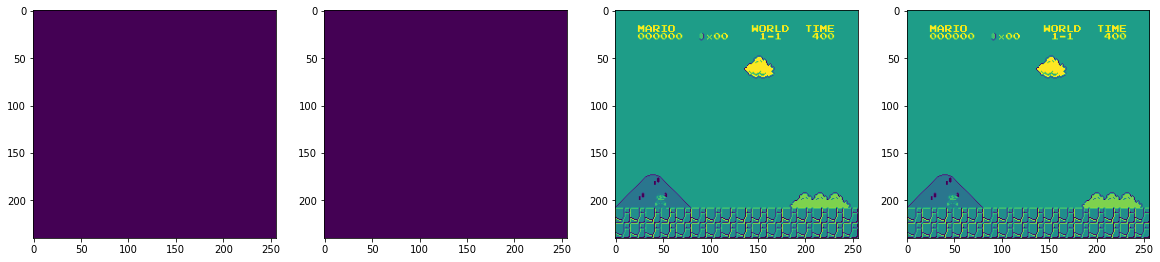

In [8]:
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

## <a id='4.'>4. Enetrenamos el Modelo</a>

Lo primero que debemos hacer es:
- Vamos a importar los modulos necesarios.

<b></b>

Lo siguiente seria:
- Crear una clase que contenga las funciones:
    - Funcion de Inico.
    - Funcion de llamado de inicio nuevamente (Callback).
    - Funcion que evalue cual es mejor modelo y reemplace si se crea un mejor.


In [9]:
# Importar os para la gestión de la ruta de archivo
import os 
# Importar PPO para la Optimización de políticas próximas
from stable_baselines3 import PPO
# Importar Base Callback para guardar los modelos
from stable_baselines3.common.callbacks import BaseCallback

1.2. Cambiar el orden de la columna

In [10]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

Indicamos las carpetas del directorio

In [11]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [12]:
# Setup model para callback de los modelos guardados
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

Ahora si, Aqui empieza el modelo de IA

Creamos el Modelo

In [13]:
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, 
            n_steps=512) 

Using cuda device
Wrapping the env in a VecTransposeImage.


Entrenamos el Modelo

In [14]:
model.learn(total_timesteps=1000000, callback=callback)

Logging to ./logs/PPO_2


C:\Users\jamr1\AppData\Local\Programs\Python\Python37\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


----------------------------
| time/              |     |
|    fps             | 27  |
|    iterations      | 1   |
|    time_elapsed    | 18  |
|    total_timesteps | 512 |
----------------------------
--------------------------------------------
| time/                   |                |
|    fps                  | 37             |
|    iterations           | 2              |
|    time_elapsed         | 27             |
|    total_timesteps      | 1024           |
| train/                  |                |
|    approx_kl            | 1.36379385e-05 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -1.95          |
|    explained_variance   | 0.00325        |
|    learning_rate        | 1e-06          |
|    loss                 | 116            |
|    n_updates            | 10             |
|    policy_gradient_loss | -5.15e-05      |
|    value_loss           | 442            |
--------------------------------

In [15]:
model.save('este_es_modelo_de_prueba')

#  <a id='5.'>5. Prueba del Modelo</a>

### Una vez que ya se ha sido entrenado el modelo procedemos a realizar una prueba.

Primero cargamos el Modelo.

In [16]:
model = PPO.load('./train/best_model_1000000')

Finalmente lo probamos.

In [17]:
state = env.reset()

while True: 
    
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()

KeyboardInterrupt: 

In [ ]:
env.close()

## <a href ='#0'>Volver al inicio</a>